In [ ]:
from volsense_pkg.forecasters.forecaster_api import (
    ARCHForecaster,
    LSTMForecaster,
    MultiVolDataset,
    train_lstm,
    evaluate_lstm,
    VolSenseForecaster
)
from volsense_pkg.utils.evaluation import evaluate_forecasts


import numpy as np
import pandas as pd

print("All imports work ✅")

All imports work ✅


In [2]:
from volsense_pkg.forecasters.forecaster_api import (
    VolSenseForecaster,
    MultiVolDataset,
)

# Example synthetic volatility data for testing LSTM
dates = pd.date_range("2020-01-01", periods=300)
tickers = ["AAPL"] * 300
vols = np.random.rand(300) * 0.05 + 0.02
df = pd.DataFrame({"date": dates, "ticker": tickers, "realized_vol": vols})

# --- LSTM test ---
lstm_f = VolSenseForecaster(method="lstm", window=30, horizon=[1,5])
lstm_f.fit(df, epochs=5, batch_size=32)  # quick training
preds, actuals = lstm_f.predict()  # by default uses val_loader
print("LSTM preds shape:", preds.shape, "actuals shape:", actuals.shape)

# --- GARCH test ---
returns = np.random.randn(500) * 0.01
garch_f = VolSenseForecaster(method="garch", p=1, q=1)
garch_f.fit(returns)
print("GARCH forecast:", garch_f.predict(horizon=5))


Epoch 1/5 | Train Loss: 1.0055 | Val Loss: 1.0294
Epoch 2/5 | Train Loss: 0.9976 | Val Loss: 1.0239
Epoch 3/5 | Train Loss: 0.9976 | Val Loss: 1.0215
Epoch 4/5 | Train Loss: 0.9969 | Val Loss: 1.0232
Epoch 5/5 | Train Loss: 0.9968 | Val Loss: 1.0281
LSTM preds shape: (54, 2) actuals shape: (54, 2)
GARCH forecast: [0.01072704 0.01072704 0.01072704 0.01072704 0.01072704]


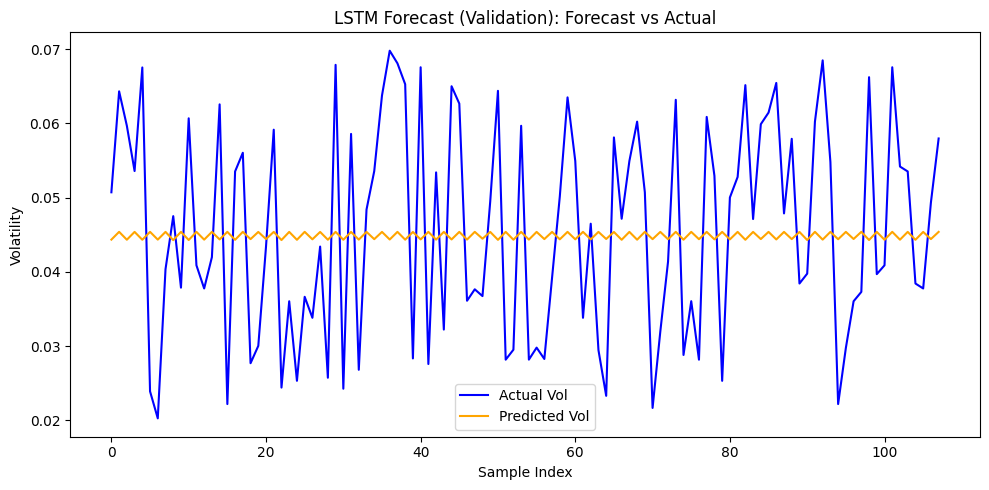

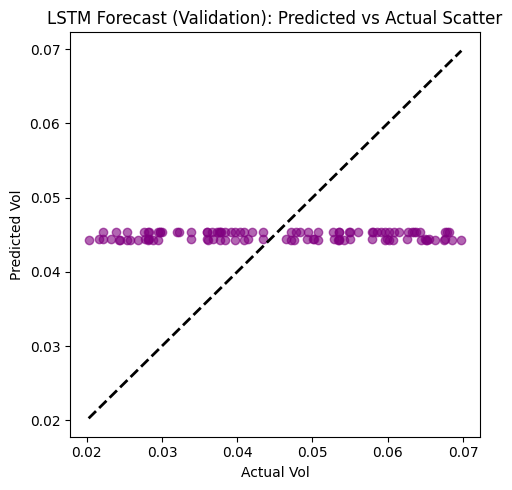

RMSE: 0.0145 | MAE: 0.0129 | Bias: -0.0009


In [3]:
# After training / predicting:
preds, actuals = lstm_f.predict()  # using your VolSenseForecaster wrapper
metrics = evaluate_forecasts(preds, actuals, title="LSTM Forecast (Validation)")

In [2]:
from volsense_pkg.data_fetching.fetch_yf import fetch_ohlcv, compute_returns_vol
import pandas as pd
import numpy as np

# Pull actual OHLCV for SPY
df = fetch_ohlcv("SPY", start="2020-01-01")

# Compute realized vol (21-day) and daily returns
df = compute_returns_vol(df, window=21, ticker="SPY")  # adds 'vol_realized' and 'returns'
df["ticker"] = "SPY"  # ensure ticker column exists
df = df.rename(columns={"vol_realized": "realized_vol"})

# We'll use the daily returns column for GARCH
returns_series = df["return"].dropna()

print(df.head())

C:\Users\rahul\OneDrive\Documents\GitHub\VolSense\volsense_pkg\data_fetching\fetch_yf.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

         date    return  realized_vol ticker
21 2020-02-03  0.007429      0.120011    SPY
22 2020-02-04  0.015241      0.127837    SPY
23 2020-02-05  0.011548      0.132694    SPY
24 2020-02-06  0.003365      0.131964    SPY
25 2020-02-07 -0.005330      0.133394    SPY


Epoch 1/5 | Train Loss: 0.8799 | Val Loss: 0.2992
Epoch 2/5 | Train Loss: 0.4131 | Val Loss: 0.1374
Epoch 3/5 | Train Loss: 0.2058 | Val Loss: 0.0616
Epoch 4/5 | Train Loss: 0.1121 | Val Loss: 0.0388
Epoch 5/5 | Train Loss: 0.0736 | Val Loss: 0.0392
LSTM RMSE: 0.198023
GARCH RMSE: 0.829791


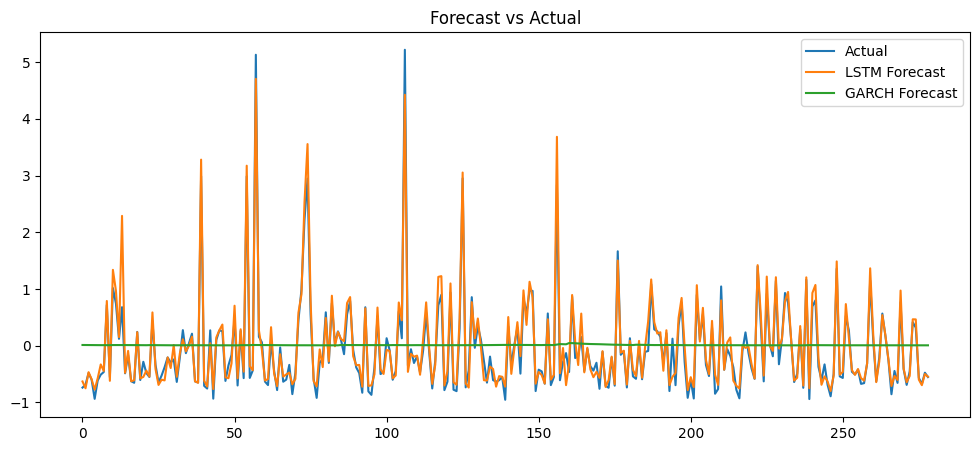

        date  realized_vol  lstm_pred_vol  garch_pred_vol
0 2025-07-30     -0.739408      -0.630800        0.012306
1 2024-06-05     -0.686629      -0.751072        0.011505
2 2023-07-21     -0.482489      -0.467333        0.010826
3 2025-07-02     -0.599587      -0.592861        0.010519
4 2025-06-16     -0.937458      -0.775465        0.010571


In [3]:
# === Fit LSTM forecaster (with built-in scaling) ===
lstm_f = VolSenseForecaster(method="lstm", window=30, horizon=1, hidden_dim=32)
lstm_f.fit(df, epochs=5, batch_size=32)

# === Fit GARCH forecaster on actual returns ===
garch_f = VolSenseForecaster(method="garch", p=1, q=1)
garch_f.fit(returns_series)

# === Evaluate & plot both LSTM + GARCH in one go ===
# VolSenseForecaster.evaluate_and_plot calls the underlying GARCHForecaster.predict()
# We’ll ask it for a rolling forecast time series:
y_pred_lstm, y_true, y_pred_garch = lstm_f.evaluate_and_plot(
    garch_forecaster=garch_f, garch_rolling=True
)

# === Build a quick DataFrame with results for further analysis ===
val_indices = lstm_f._val_loader.dataset.indices
val_dates = df.iloc[val_indices]["date"].reset_index(drop=True)

results_df = pd.DataFrame({
    "date": val_dates,
    "realized_vol": y_true,
    "lstm_pred_vol": y_pred_lstm,
    "garch_pred_vol": y_pred_garch
})

print(results_df.head())